# Category Prediction on BBC-news data

In [8]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from helper import *

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score 
from sklearn.metrics import average_precision_score, recall_score

data_dir = './'

In [2]:
import json

with open(data_dir+"label_dict.json", 'r') as fp:
    label_dict = json.load(fp)

with open(data_dir+"label_dict_reversed.json", 'r') as fp:
    label_dict_reversed = json.load(fp)

print (label_dict, label_dict_reversed)
df = pd.read_csv(data_dir+'bbc_text_processed.csv')
print ('data.shape:',df.shape)
df.head(2)

{'tech': 0, 'business': 1, 'sport': 2, 'entertainment': 3, 'politics': 4} {'0': 'tech', '1': 'business', '2': 'sport', '3': 'entertainment', '4': 'politics'}
data.shape: (2225, 5)


,category,text,label,text_processed,text_len
0,tech,tv future in the hands of viewers with home th...,0,tv futur hand viewer home theatr system plasma...,407
1,business,worldcom boss left books alone former worldc...,1,worldcom boss left book alon former worldcom b...,186


## Bag of Words Method

In [3]:
from collections import Counter
ALL_WORDS = [word for text in df['text_processed'] for word in text.split() ]
words_counts = Counter(ALL_WORDS)


In [4]:
DICT_SIZE = 1000
VOCAB = words_counts.most_common(DICT_SIZE)
WORDS_TO_INDEX = {item[0]:ii for ii, item in enumerate(VOCAB) }
INDEX_TO_WORDS = {ii:word for word, ii in WORDS_TO_INDEX.items()}

In [5]:
from collections import Counter
from scipy import sparse as sp_sparse

ALL_WORDS = [word for text in df['text_processed'] for word in text.split() ]
words_counts = Counter(ALL_WORDS)

def bag_of_words(text, words_to_index):
    result_vec = np.zeros(len(words_to_index.keys()))
    for word in text.split():
        if word in words_to_index:
            result_vec[words_to_index[word]] +=1
    return result_vec

def prepare_BOW(df, col):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state = 8848)
    X_train_bow = sp_sparse.vstack([ sp_sparse.csr_matrix(bag_of_words(text,
                                                                       WORDS_TO_INDEX)) for text in df_train[col]])
    X_test_bow = sp_sparse.vstack([ sp_sparse.csr_matrix(bag_of_words(text,
                                                                      WORDS_TO_INDEX)) for text in df_test[col]])

    y_train = df_train['label'].values
    y_test  = df_test['label'].values
    
    print('X_train shape ', X_train_bow.shape)
    print('X_test shape ',  X_test_bow.shape)
    print('y_train shape ', y_train.shape)
    print('y_test shape ',  y_test.shape)
    
    return X_train_bow, X_test_bow, y_train, y_test

X_train_bow, X_test_bow, y_train_bow, y_test_bow = prepare_BOW(df, "text_processed")

X_train shape  (1780, 1000)
X_test shape  (445, 1000)
y_train shape  (1780,)
y_test shape  (445,)


## Model : Linear Discriminant Analysis (LDA) for  BOW method

In [6]:
X_train_bow.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [3., 3., 1., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 2.],
       [1., 0., 3., ..., 0., 0., 0.]])

In [9]:
model_LDA = LDA()
model_LDA.fit(X_train_bow.toarray(), y_train_bow)

LinearDiscriminantAnalysis()

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93        81
           1       0.87      0.87      0.87        89
           2       0.84      0.96      0.90        94
           3       0.88      0.94      0.91        94
           4       0.92      0.77      0.84        87

    accuracy                           0.89       445
   macro avg       0.89      0.89      0.89       445
weighted avg       0.89      0.89      0.89       445




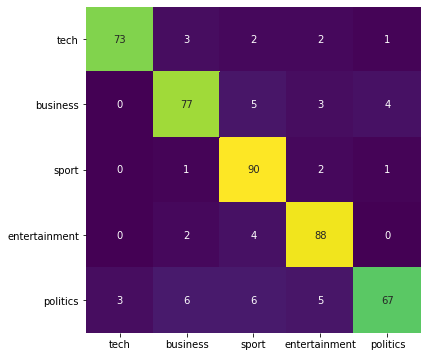

In [10]:
calc_prediction(model_LDA, X_test_bow, y_test_bow, categorical=False, ax=None, title=None)

## Predictions for new texts

In [22]:
def Prediction_bow(doc, model=model_LDA, WORDS_TO_INDEX=WORDS_TO_INDEX):
    doc_processed = process_text(doc)
    X_in = sp_sparse.vstack([ sp_sparse.csr_matrix(bag_of_words(doc_processed,
                                                                WORDS_TO_INDEX)) ])
    y_out = model.predict(X_in)[0]
    #print (y_out, label_dict_reversed)
    category = label_dict_reversed[str(y_out)]
    
    #print (f"The following text\n\n {doc} \n\n\
    print (f"Bag of Words Prediction \t {category}")

In [23]:
test_docs = get_test_doc()

for doc in test_docs:
    print ("The given doc :\n",doc[:150],"...\n")
    Prediction_bow(doc)
    print ()

The given doc :
 Mr Trump responded on Tuesday with his lengthiest statement since he left office a month ago. The Republican Party can never again be respected or str ...

Bag of Words Prediction 	 sport

The given doc :
 England were bowled out for 134 and 164, losing all 10 second-innings wickets to spin as India levelled the four-match series at 1-1. A dry pitch was  ...

Bag of Words Prediction 	 sport

The given doc :
  R. Ashwin took 5 wickets in what became the last innings of the series to secure an innings and a 25 runs. ...

Bag of Words Prediction 	 sport

The given doc :
 True Thompson makes an adorable cameo in Khloe Kardashian's new makeup tutorial video. Many people didn't like it. ...

Bag of Words Prediction 	 sport

